In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel       = True
parallel_nprc     = 48   # number of dask workers
parallel_nprc_bin = 10   # number of processor used to parallize the binning loop
parallel_tmem     = 200  # max. available RAM

/albedo/home/pscholz/tripyview/tripyview/sub_data.py:8: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

 --> memory_limit: 4.167 GB


In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = '~/tripyview/Results/test_newploting/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= 5 #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'hslice'

#_____________________________________________________________________________________
input_paths= list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names= list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'temp'
year      = [2000, 2019]
mon, day, record, box, depth = None, None, None, None, 1000

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None #
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None #[1979, 2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'wbgyr', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
do_clim   = False
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cstr, cnum = 'blue2red', 20
cref, crange, cmin, cmax, cfac, climit = None, None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncol      = 2        # number of pannel columns in figure
do_rescale= None #'log10'
which_dpi = 300
proj      = 'pc'
do_plot   = 'tcf'
do_reffig = True
figfac    = [8, 3.5] # [7, 3.5]

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl != None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if (ref_path != None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
        
#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None) and (ref_path != "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
else:
    do_reffig=False
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path != None) and (ref_path != "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.jlib file: tripyview_fesom2_core2_srt_dep@node_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/
1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/
2 /albedo/

# > Hslice:

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 --> elasped time to load data: 0.06 min.
 --> data uses 0.00 Gb:

1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 --> elasped time to load data: 0.05 min.
 --> data uses 0.00 Gb:

2 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
 --> elasped time to load data: 0.04 min.
 --> data uses 0.00 Gb:

3 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load data: 0.04 min.
 --> data uses 0.00 Gb:

--> cmin/cmax: norm: -1.548024/13.746941, hist: -1.158002/8.018977, fin: -1.158002/8.018977
--> cmin/cmax: norm: -0.389586/13.528822, hist: 0.299375/7.717886, fin: -1.158002/8.018977
--> cmin/cmax: norm: -0.395321/13.507444, hist: 0.292866/7.661331, fin: -1.158002/8.018977
--> cmin/cmax: norm: -0.271730

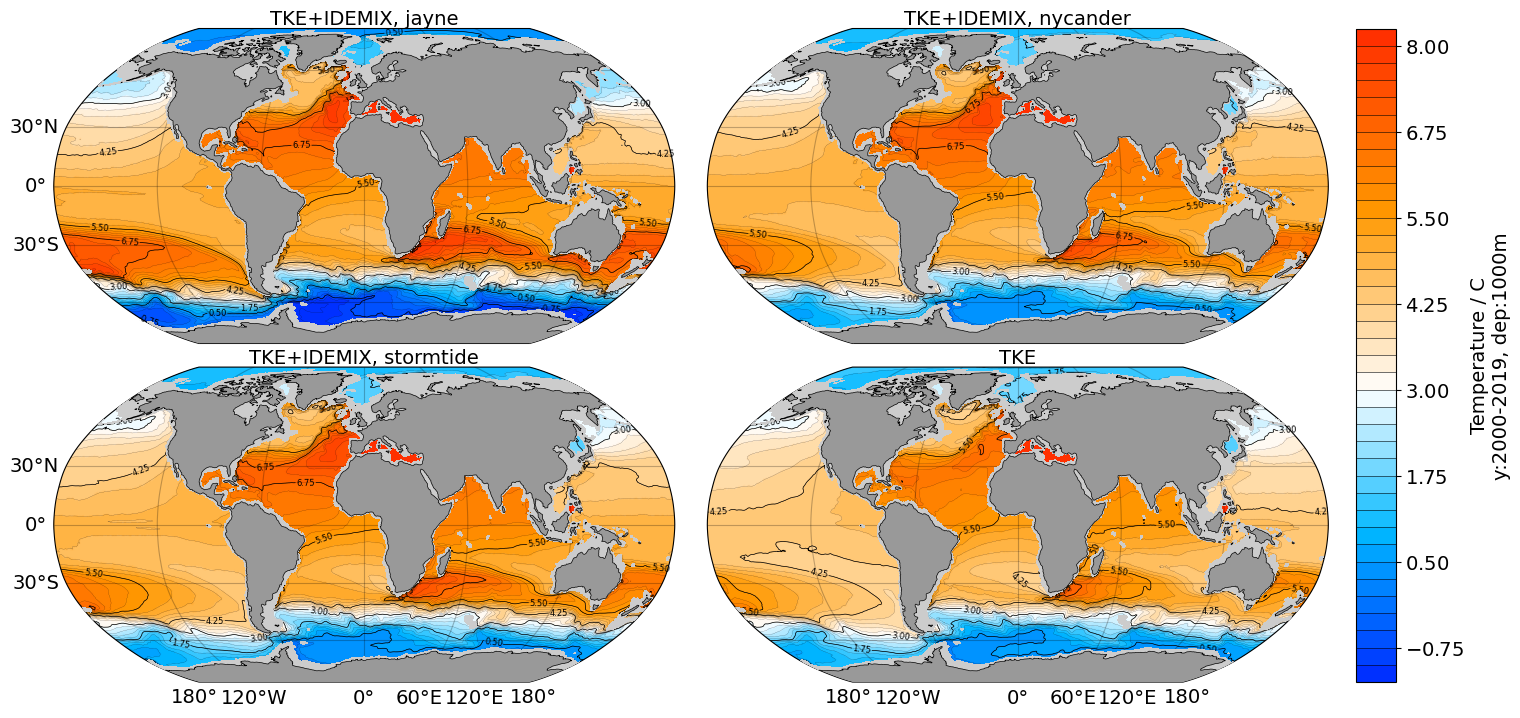

In [5]:
data_list = list()
vname     = 'temp'
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None and ref_path != 'None'): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    
    #__________________________________________________________________________________________________
    if depth =='bottom':
        data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, day=dayi, record=recordi, 
                                    depth=None, descript=descript, do_info=False) 
        data = data.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
    else:
        #______________________________________________________________________________________________
        if vname=='Kv*N2':
            data  = tpv.load_data_fesom2(mesh, datapath, vname='Kv', year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=False) 
            data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2', year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=False) 
            data['Kv'].data = data['Kv'].data * data2['N2'].data
            data = data.rename(dict({'Kv':'Kv*N2'}))
            data['Kv*N2'].attrs['units'], data['Kv*N2'].attrs['description'], data['Kv*N2'].attrs['long_name'] =  '$m^2/s^3$', '(Kv)*(N^2)', '$\\overline{{Kv}} \\cdot \\overline{{N^2}}$'
            del(data2)
        #______________________________________________________________________________________________
        elif vname=='KvN2/N2':
            data  = tpv.load_data_fesom2(mesh, datapath, vname='KvN2' , year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=False)
            data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2'   , year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=False)
            data['KvN2'].data = data['KvN2'].data / data2['N2'].data
            data  = data.rename(dict({'KvN2':'KvN2/N2'}))
            data['KvN2/N2'].attrs['units'], data['KvN2/N2'].attrs['description'], data['KvN2/N2'].attrs['long_name'] = '$m^2/s$', '(Kv*N)/N2', '$\\overline{{Kv \\cdot N^2}} / \\overline{{N^2}}$'
            del(data2) 
        #______________________________________________________________________________________________
        elif vname=='iwe_Tbot':    
            data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=None, descript=descript, do_info=False, do_nan=False) 
            data = data.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
            data = data * xr.DataArray(mesh.zlev[mesh.n_iz-1]-mesh.zlev[mesh.n_iz], dims='nod2') * 1030 * 0.5
            # compute global value of total energy input in TW
            aux  = data['iwe_Tbot'].copy()*xr.DataArray(mesh.n_area, dims='nod2')*1.0e-12
            data['iwe_Tbot'].attrs['descript'] = '{:s}, $E_{{tot}}$={:2.3f} TW'.format(data['iwe_Tbot'].attrs['descript'], aux.sum(dim='nod2').data)
        #______________________________________________________________________________________________
        elif vname=='EKE':
            data  = tpv.load_data_fesom2(mesh, datapath, vname='ke_Umean', year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=True, do_ie2n=False) 
            datau2 = tpv.load_data_fesom2(mesh, datapath, vname='ke_U2mean', year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=True, do_ie2n=False) 
            data['ke_Umean'].data = datau2['ke_U2mean'].data/2 - (data['ke_Umean'].data**2)/2
            
            datau  = tpv.load_data_fesom2(mesh, datapath, vname='ke_Vmean', year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=True, do_ie2n=False) 
            datau2 = tpv.load_data_fesom2(mesh, datapath, vname='ke_V2mean', year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=True, do_ie2n=False)   
            data['ke_Umean'].data = data['ke_Umean'].data + datau2['ke_V2mean'].data/2 - (datau['ke_Vmean'].data**2)/2
                                
            data = data.rename(dict({'ke_Umean':'EKE'}))
            data['EKE'].attrs['units'], data['EKE'].attrs['description'], data['EKE'].attrs['long_name'] =  '$m^2/s^2$', 'EKE', 'Eddy Kinetic Energy'
            del(datau, datau2)
        #______________________________________________________________________________________________    
        else:
            data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=False)
            
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
        
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________    
    # create reference data if given 
    if (ii==0) and (ref_path != None and ref_path != 'None'):
        data_ref = data
        if do_reffig: data_list.append(data_ref) 
        continue
        
    #__________________________________________________________________________________________________    
    # compute anomaly 
    if (ref_path != None and ref_path != 'None'):
        data_list.append(tpv.do_anomaly(data, data_ref))  
    # compute absolute    
    else:
        data_list.append(data)  
    del(data)
if (ref_path != None and ref_path != 'None'): del(data_ref)    
    
    
#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and (depth != 'bottom') and do_clim and (ref_path is None): 
    ts = clock.time()
    clim_vname = vname
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, depth=depth)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> clim uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))
    data_list.append(clim)    
    del(clim)

ncol=2
nrow = np.ceil(len(data_list)/(np.min([ncol, len(data_list)]))).astype(np.int32)
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo, box=[-180, 180, -90, 90], nrow=nrow, ncol=ncol, proj='rob', 
                               do_plt='tpc', plt_contb=True, plt_contf=True, plt_contr=False, plt_contl=True, do_enum=False, 
                               ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':True, 'cb_plt_single':True, 'cb_pos':'vertical', 'cb_h':'auto'}),
                               do_save=os.path.join(save_path,'test_hslice.png'), )
                                                                         

# > Hslice: Mesh plot

 > load e_area from fesom.mesh.diag.nc
 > load n_area from fesom.mesh.diag.nc
 > compute lsmask
 > save *.shp to /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/tripyview_fesom2_core2_srt_dep@node_pbnd.shp
 > augment lsmask
 > save *.shp to /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/tripyview_fesom2_core2_srt_dep@node_focus=0.shp


/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


 > load e_area from fesom.mesh.diag.nc
 > load n_area from fesom.mesh.diag.nc
 > compute lsmask
 > save *.shp to /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/tripyview_fesom2_core2_srt_dep@node_pbnd.shp
 > augment lsmask
 > save *.shp to /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/tripyview_fesom2_core2_srt_dep@node_focus=0.shp


/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


 > save figure: /albedo/home/pscholz/tripyview/Results/test_newploting/test_hmesh.png


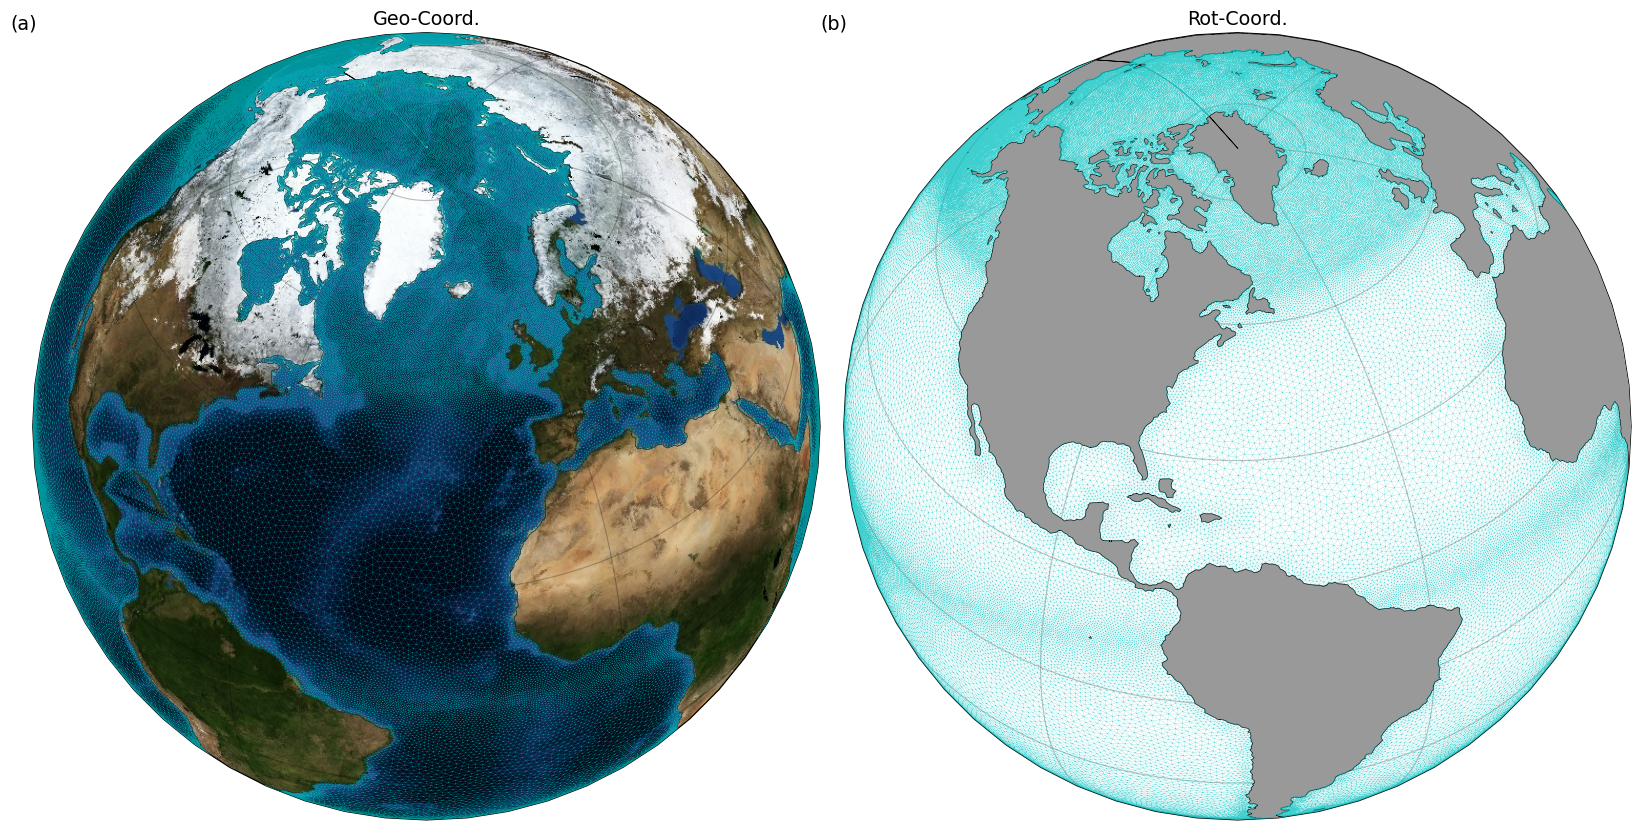

In [6]:
ncol, nrow = 2, 1
mesh1=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=False, do_pickle=False)
mesh2=tpv.load_mesh_fesom2(mesh_path, do_rot='g2r' , focus=0, do_info=False, do_pickle=False)
hfig, hax, hcb = tpv.plot_hmesh([mesh1, mesh2], data=None, box=[-30,45], nrow=nrow, ncol=ncol, proj='ortho', 
                               ax_opt=dict({'fig_sizefac':5.0, 'cb_plt':False}),
                               ax_title=['Geo-Coord.', 'Rot-Coord.'],
                               do_enum=True, do_lsm=['bluemarble', 'fesom'], mesh_opt=dict({'color':'c', 'linewidth':0.15}),
                               do_save=os.path.join(save_path,'test_hmesh.png'), save_dpi=600, 
                                )

# > Hslice: Quiver plot

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 > do elem vector rotation


/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.41 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 9.61 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


 > do interpolation e2n
 --> elasped time to load data: 0.17 min.
 --> data uses 0.00 Gb:

{'cstr': 'wbgyr', 'cnum': 20, 'chist': True, 'ctresh': 0.995, 'crange': [0, 0.25, 0.125], 'cnlab': 8, 'cmin': 0, 'cmax': 0.25, 'cref': np.float64(0.125), 'cmap': <matplotlib.colors.ListedColormap object at 0x7f21d2cad760>, 'clevel': array([-0.005,  0.005,  0.015,  0.025,  0.035,  0.045,  0.055,  0.065,
        0.075,  0.085,  0.095,  0.105,  0.115,  0.125,  0.135,  0.145,
        0.155,  0.165,  0.175,  0.185,  0.195,  0.205,  0.215,  0.225,
        0.235,  0.245,  0.255]), 'clab': array([0.005, 0.045, 0.085, 0.125, 0.165, 0.205, 0.245])}
 > save figure: /albedo/home/pscholz/tripyview/Results/test_newploting/test_hquiver.png


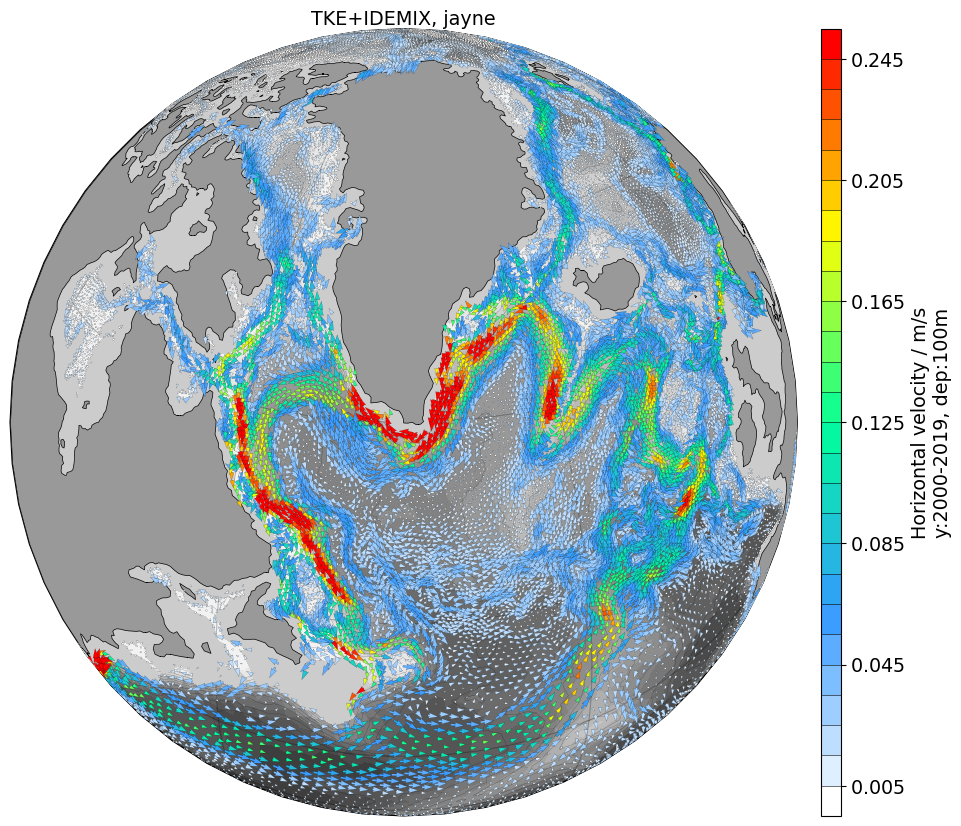

In [7]:
data_list = list()
vname = 'vec+u+v'
depth = 100
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None and ref_path != 'None'): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, day=dayi, record=recordi, 
                                depth=depth, descript=descript, do_info=False)
            
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
        
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    data_list.append(data)  
    if ii==0: break 
    del(data)

 
cinfo2 = cinfo.copy()
cinfo2.update({'cstr':'wbgyr', 'crange':[0, 0.25, 0.125]})
hfig, hax, hcb = tpv.plot_hquiver(mesh, data_list, cinfo=cinfo2, box=[-45, 60, 25], nrow=1, ncol=1, proj='nears',
                               ax_opt=dict({'fig_sizefac':5.0, 'cb_plt':True, 'cb_plt_single':True, 'cb_pos':'vertical', 'cb_h':'auto'}),
                               quiv_scalfac=1.0, quiv_arrwidth=0.2, quiv_dens=0.4, quiv_smax=10, 
                               do_save=os.path.join(save_path,'test_hquiver.png'), )

# > Index vs. depth vs. xy: Zonal Mean Section

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 --> elasped time to load data: 0.01 min.
 --> data uses 0.05 Gb:

1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 --> elasped time to load data: 0.00 min.
 --> data uses 0.05 Gb:

2 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
 --> elasped time to load data: 0.01 min.
 --> data uses 0.05 Gb:

3 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load data: 0.00 min.
 --> data uses 0.05 Gb:

--> histo: cmin, cmax =  -1.797586441040039 27.432350158691406
--> histo: cmin, cmax =  -1.797586441040039 27.441370010375977
--> histo: cmin, cmax =  -1.797586441040039 27.443180084228516
--> histo: cmin, cmax =  -1.797586441040039 27.443180084228516
{'cstr': 'blue2red', 'cnum': 20, 'chist': True, 'ctr

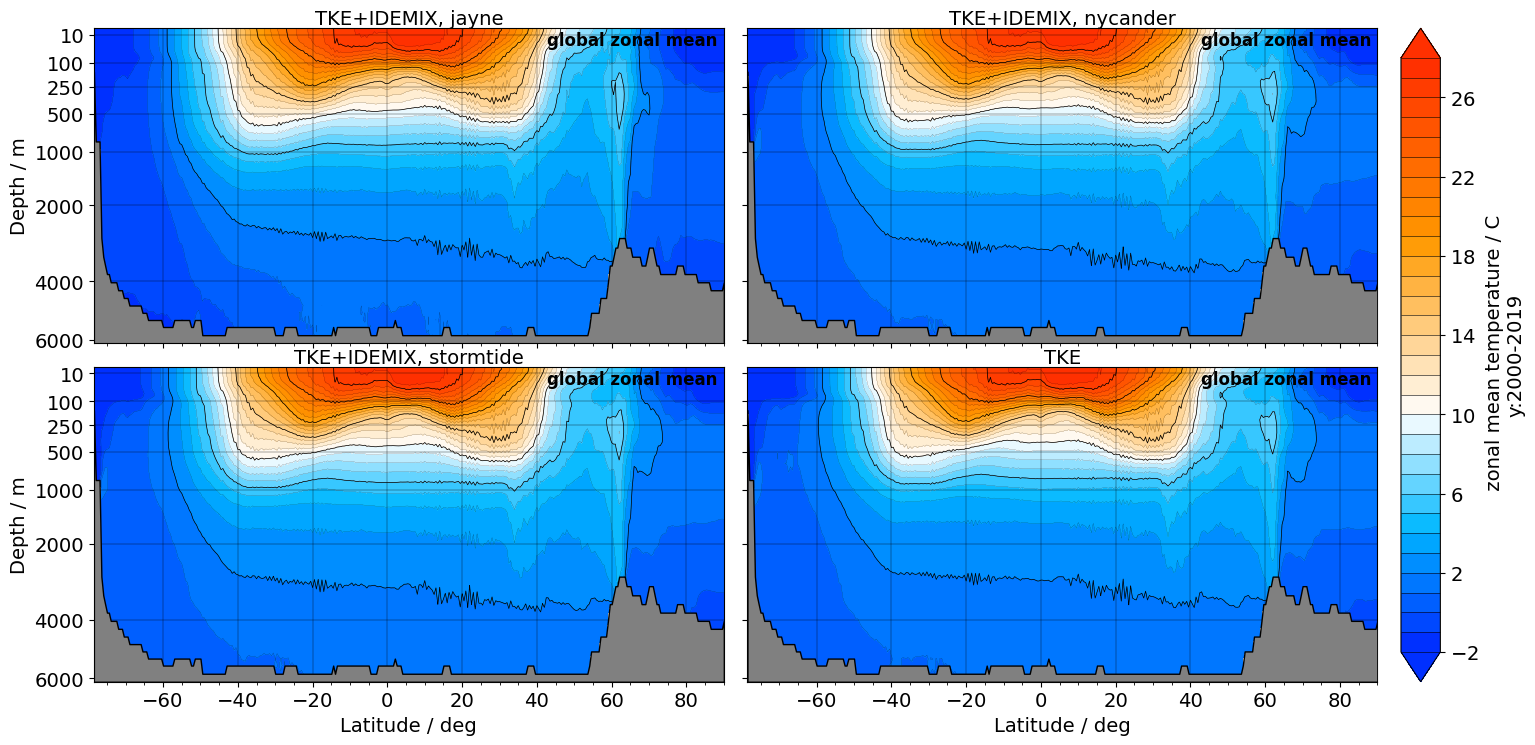

In [8]:
box_region = list()
box_region.append('global')

#________________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_region:
    if region == 'global' or isinstance(region,list): box.append(region)
    else: box.append(shp.Reader(os.path.join(shp_path,region)))     

#______________________________________________________________________________________________________        
data_list = list()
vname = 'temp'
depth = None
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None and ref_path != 'None'): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, day=dayi, record=recordi, 
                                depth=depth, descript=descript,  do_zarithm=None, do_load=False, do_persist=True, do_info=False)
            
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
        
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    data_list.append(tpv.load_zmeantransect_fesom2(mesh, data, box))
    del(data)        

#______________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=2, ncol=2, box=box, box_idx=0, cinfo=dict({'cstr':'blue2red','cnum':20}), do_enum=False, 
                                  do_plt='tcf', plt_contb=True, plt_contf=True, plt_contr=False, plt_contl=False, ax_opt=dict({'fig_sizefac':2}), 
                                  do_save=os.path.join(save_path,'test_vslice_index.png') )

# > Index vs. depth vs. xy: MOC

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
--> histo: cmin, cmax =  -3.3088998794555664 13.23258113861084
--> histo: cmin, cmax =  -3.3088998794555664 14.178462028503418
--> histo: cmin, cmax =  -3.3088998794555664 14.230483055114746
--> histo: cmin, cmax =  -3.3088998794555664 14.230483055114746
{'cstr': 'blue2red', 'cnum': 20, 'cref': np.int64(0), 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(-3.31), 'cmax': np.float64(14.23), 'cmap': <matplotlib.colors.ListedColormap object at 0x7f21ea8bd9a0>, 'clevel': array([-3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,
        2. ,  2.5,  3

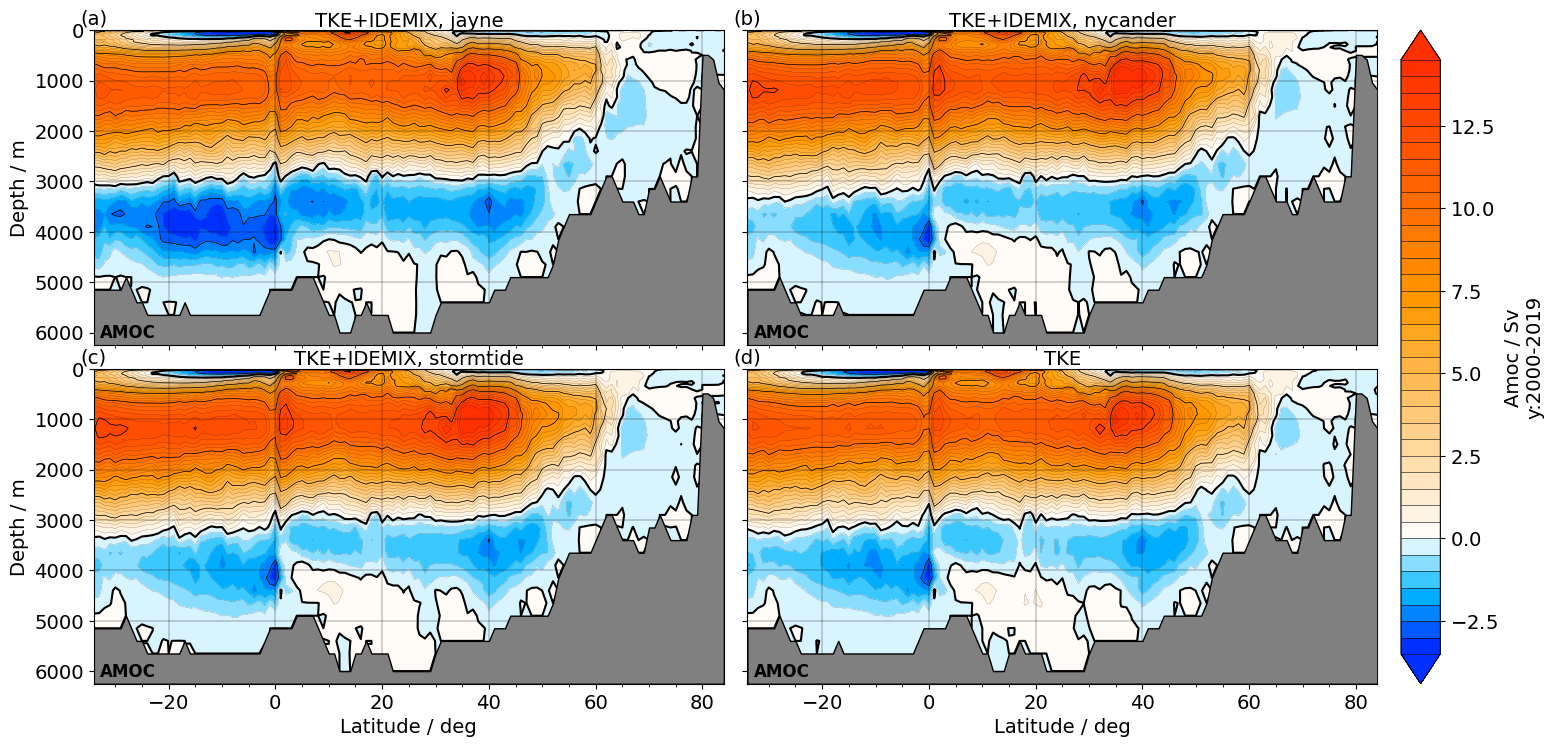

In [9]:
aux_vname, aux_vnamebv = 'w', 'bolus_w'
#______________________________________________________________________________________________________    
data_list = list()
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)): 
    print(datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    # load data
    data = tpv.load_data_fesom2(mesh, datapath, vname=aux_vname, year=year, descript=descript, 
                                do_info=False, do_zarithm=None, do_nan=False, #chunks=chunks,
                                do_load=False, do_persist=True, )
    #__________________________________________________________________________________________________        
    # compute zmoc  
    zmoc     = tpv.calc_zmoc(mesh, data, dlat=1.0, which_moc='amoc', do_info=False, do_checkbasin=False,
                             do_onelem=False, do_load=True, do_parallel=do_parallel, n_workers=30)
    #__________________________________________________________________________________________________        
    # compute absolute or anomalie    
    data_list.append( zmoc )
    del(zmoc, data) 

#______________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=2, ncol=2, cinfo=dict({'cstr':'blue2red','cnum':20,'cref':0}), 
                                 do_plt='cf', plt_contb=True, plt_contf=True, plt_contr=True, plt_contl=False, 
                                 ax_opt=dict({'fig_sizefac':2}), 
                                 do_enum=True, 
                                 do_save=os.path.join(save_path,'test_vslice_zmoc.png') )

# > Index vs. depth vs. xy: DMOC

In [10]:
vname        = 'amoc'
which_transf = 'dmoc' # 'srf', 'inner', 'dmoc'
do_useZinfo  = 'std_dens_H' 
do_zcoord    = True
do_bolus     = True 

# my density layers 2nd try
std_dens=[ 0.00000, 29.50000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
          32.77778, 33.01000, 33.33333, 33.56000, 33.78170, 33.79659, 33.81331, 33.83206, 33.85258, 33.87502,
          33.88889, 33.90019, 33.92843, 33.96012, 33.99567, 34.03267, 34.07050, 34.11295, 34.16058, 34.21400,
          34.27274, 34.33865, 34.41114, 34.47728, 34.55149, 34.62872, 34.71458, 34.81014, 34.91325, 35.02337,
          35.13865, 35.25518, 35.37026, 35.48624, 35.58763, 35.67886, 35.76112, 35.82097, 35.87630, 35.92691,
          35.97247, 36.02033, 36.06813, 36.11950, 36.17459, 36.23291, 36.29566, 36.36239, 36.43058, 36.50178,
          36.57474, 36.64730, 36.71590, 36.77414, 36.82096, 36.85908, 36.89139, 36.91962, 36.94532, 36.96900,
          36.98623, 37.00269, 37.01746, 37.03056, 37.04018, 37.05134, 37.06372, 37.07111, 37.10000, 37.25556,
          37.41111, 37.56667, 37.72222, 37.87778, 38.03333, 38.18889, 38.34444, 38.50000, 40.00000]

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 --> elasped time to load data: 0.15 min.
 --> data uses 0.41 Gb:

 --> elasped time to comp. dmoc: 0.05 min.
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 --> elasped time to load data: 0.15 min.
 --> data uses 0.41 Gb:

 --> elasped time to comp. dmoc: 0.03 min.
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
 --> elasped time to load data: 0.15 min.
 --> data uses 0.41 Gb:

 --> elasped time to comp. dmoc: 0.03 min.
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load data: 0.15 min.
 --> data uses 0.41 Gb:

 --> elasped time to comp. dmoc: 0.03 min.
--> histo: cmin, cmax =  -4.341435062557696 17.103056506991194
--> histo: cmin, cmax =  -4.897364538165057 17.86969488421668
--> histo: cmin

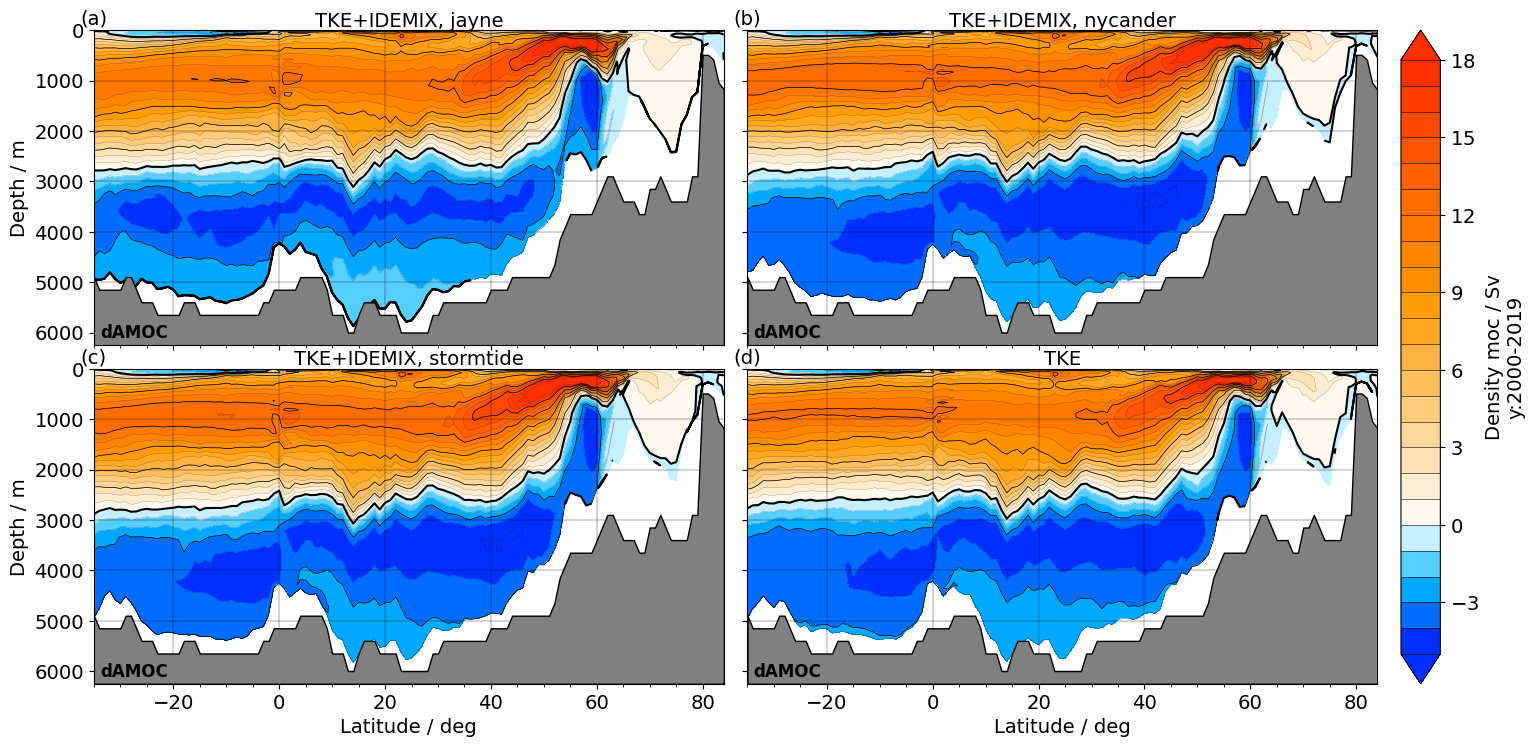

In [11]:
#___LOAD FESOM2 DATA___________________________________________________________________________________    
data_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________    
    data = tpv.load_dmoc_data(mesh, datapath, descript, year, which_transf, std_dens, 
                      do_info=False, do_zcoord=do_zcoord, 
                      do_useZinfo=do_useZinfo, do_bolus=do_bolus, do_load=False, do_persist=True)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
   
    #___COMPUTE XMOC___________________________________________________________________________________
    ts = clock.time()
    dmoc     = tpv.calc_dmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=False, do_checkbasin=False, 
                             do_parallel=do_parallel, n_workers=parallel_nprc_bin)
    print(' --> elasped time to comp. dmoc: {:3.2f} min.'.format( (clock.time()-ts)/60  ))   
    if (ref_path != None) and (ref_path != "None"): 
        if ii == 0: 
            dmoc_ref = dmoc.copy()
            if do_reffig: dmoc_list.append(dmoc_ref) 
        else:        
            data_list.append( tpv.do_anomaly(dmoc, dmoc_ref) )
    else:                                                   
        data_list.append( dmoc )

#______________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=2, ncol=2, cinfo=dict({'cstr':'blue2red','cnum':20,'cref':0}), 
                                 do_plt='cf', plt_contb=True, plt_contf=True, plt_contr=True, plt_contl=False, 
                                 ax_opt=dict({'fig_sizefac':2}), 
                                 do_enum=True, grid_opt=dict({'do_ysigma':True}),
                                 do_save=os.path.join(save_path,'test_vslice_dmoc.png') )        

# > Index vs. depth vs. xy: Transect

Drake Passage


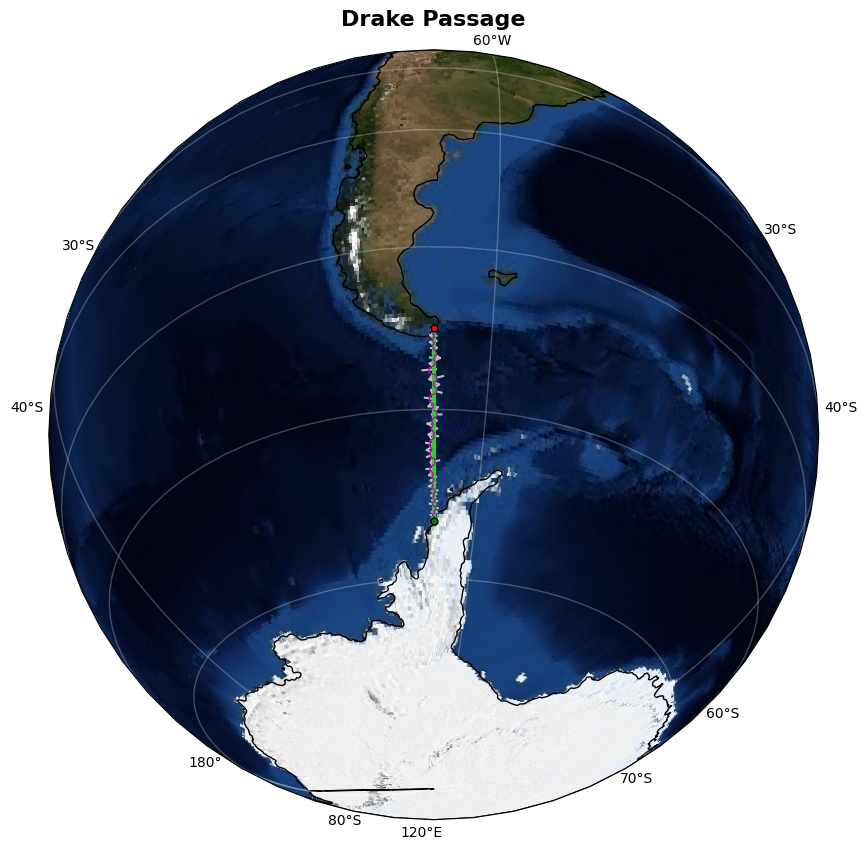

 --> elasped time: 0.04529375632603963 min.


In [12]:

#_____________________________________________________________________________________
input_transect = list()
input_transect.append([[-66, -66],[-67, -55], 'Drake Passage'])
do_edgevec_r2g = False
#______________________________________________________________________________________________________    
# load information about edges 
ts = clock.time()
datapath = input_paths[0]
fname    = 'fesom.mesh.diag.nc'
# check for directory with diagnostic file
if   os.path.isfile( os.path.join(datapath, fname) ): 
    dname = datapath
elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/'), fname) ): 
    dname = os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/')
elif os.path.isfile( os.path.join(mesh.path,fname) ): 
    dname = mesh.path
else:
    raise ValueError('could not find directory with...mesh.diag.nc file')    

#___________________________________________________________________________
# set specfic type when loading --> #convert to specific precision
# drop unnecessary variables:  Based on the documentation (but a bit hidden), 
# the "data_vars=" argument only works with Python 3.9.
from functools import partial
var_keep = ['edges', 'edge_tri', 'edge_cross_dxdy', 'nod_in_elem2D']
def _preprocess(x):
    for var in list(x.keys()):
        if var not in var_keep: 
            x = x.drop_vars(var)
            continue
        if x[var].dtype=='float64': x[var] = x[var].astype('float32')
    return x
partial_func = partial(_preprocess)

#___________________________________________________________________________
# load diag file --> apply drop variables by preprocessor function
mdiag = xr.open_mfdataset(os.path.join(dname,fname), parallel=False, 
                             chunks=dict({'edg_n':'auto'}), engine='netcdf4', 
                             preprocess=partial_func)
mdiag = mdiag.drop_vars(list(mdiag.coords)).load()

# node indices of edge points [2 x n2ded]
edge       = mdiag['edges'].values-1
# element indices of triangles that are left and right of edg: [2 x n2ded]
edge_tri   = mdiag['edge_tri'].values-1
# dx & dy of edge midpoints towards element centroid of left and right triangle
edge_dxdy  = mdiag['edge_cross_dxdy'].values[:]

# Be sure that the edge_cross_dxdy variable is in the same rotational frame as your velocities. By default
# edge_cross_dxdy is in rotated coordinates. So if you velocities are also in rotated coordinates things are fine.
# If your velocities should be in geo coordinates than edge_cross_dxdy needs to be rotated as well into geo
# coordinates (do_edgevec_r2g=True)
if (do_edgevec_r2g):
    edm_x = mesh.n_x[edge].sum(axis=0)/2.0
    edm_y = mesh.n_y[edge].sum(axis=0)/2.0
    edge_dxdy[0,:], edge_dxdy[1,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[0,:], edge_dxdy[1,:], gridis='geo', do_info=False )
    edge_dxdy[2,:], edge_dxdy[3,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[2,:], edge_dxdy[3,:], gridis='geo', do_info=False )
    del(edm_x, edm_y)
    
# [L]eft  triangle: dx, dy
edge_dxdy_l= np.array([ edge_dxdy[0,:], edge_dxdy[1,:]])
# [R]ight triangle: dx, dy
edge_dxdy_r= np.array([ edge_dxdy[2,:], edge_dxdy[3,:]])
edge_dxdy_r[:, edge_tri[1,:]<0]=0. # if boundarie edge --> right triangle doesnot exist
del(edge_dxdy)

# only needed for plotting transects when scalar data are on elements 
nodeinelem = mdiag['nod_in_elem2D'].values[:,:]-1

#______________________________________________________________________________________________________    
# analyse transects computes all neccesary arrays 
transects = tpv.do_analyse_transects(input_transect, mesh, edge, edge_tri, edge_dxdy_l, edge_dxdy_r)
for transect in transects:
    print(transect['Name'])
    fig, ax = tpv.plot_transect_position(mesh, transect, edge=edge)

print(' --> elasped time: {} min.'.format( (clock.time()-ts)/60  ))

In [13]:
data_list = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None and ref_path != 'None'): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    data  = tpv.load_data_fesom2(mesh, datapath, vname='temp', year=yeari, mon=moni, descript=descript,
                                     do_info=False, do_zarithm='None', do_ie2n=False,  
                                     do_nan=False)#**{'chunks': {'elem':1e4}})

    # compute section on data
    csect = tpv.calc_transect_scalar(mesh, data, transects, nodeinelem=nodeinelem) 
    del(data)
    data_list.append(csect)  

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
2 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
3 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE


--> histo: cmin, cmax =  -1.2240137124457244 7.4808123871015395
--> histo: cmin, cmax =  -1.2240137124457244 7.4808123871015395
--> histo: cmin, cmax =  -1.2240137124457244 7.4808123871015395
--> histo: cmin, cmax =  -1.2240137124457244 7.4808123871015395
{'cstr': 'blue2red', 'cnum': 20, 'cref': np.int64(0), 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(-1.22), 'cmax': np.float64(7.48), 'cmap': <matplotlib.colors.ListedColormap object at 0x7f21d9575250>, 'clevel': array([-1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,
        1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,
        3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25,
        5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ]), 'clab': array([-1.25,  0.  ,  1.25,  2.5 ,  3.75,  5.  ,  6.25,  7.5 ])}
 > save figure: /albedo/home/pscholz/tripyview/Results/test_newploting/test_vslice_transect.png


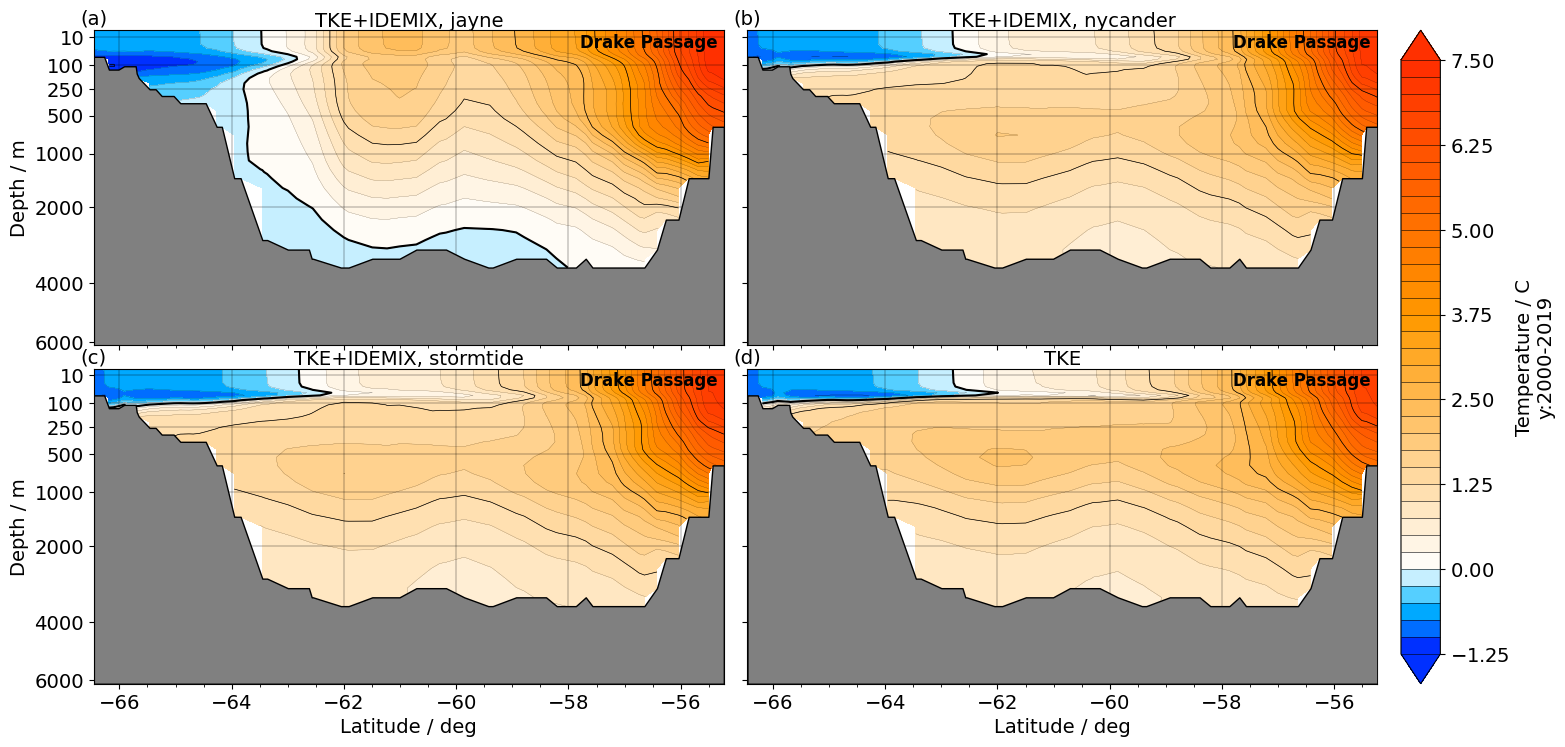

In [14]:
#______________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=2, ncol=2, box_idx=0, cinfo=dict({'cstr':'blue2red','cnum':20,'cref':0}), 
                                 do_plt='cf', plt_contb=True, plt_contf=True, plt_contr=True, plt_contl=False, 
                                 ax_opt=dict({'fig_sizefac':2}), 
                                 do_enum=True, 
                                 do_save=os.path.join(save_path,'test_vslice_transect.png') )

# > Index vs. depth vs. time: Hovmoeller Diagram

In [15]:
input_paths1= list()
input_paths1.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
input_paths1.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths1.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths1.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')

input_names1= list()
input_names1.append('TKE')
input_names1.append('TKE+IDEMIX, stormtide')
input_names1.append('TKE+IDEMIX, nycander')
input_names1.append('TKE+IDEMIX, jayne')

box_region = list()
box_region.append('global')
# box_region.append('ocean_basins/Arctic_Basin.shp')
# box_region.append('ocean_basins/Eurasian_Basin.shp')
# box_region.append('mpas_region/Canada_Basin.shp')

#______________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_region:
    if region == 'global' or isinstance(region,list): 
        print('global')
        box.append(region)
    else: 
        print(tpv.__path__[0],region)
        box.append(shp.Reader(os.path.join(shp_path,region)))    

#___LOAD FESOM2 DATA___________________________________________________________________________________
data_list = list()
for ii, (datapath, descript) in enumerate(zip(input_paths1, input_names1)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    data  = tpv.load_data_fesom2(mesh, datapath, vname='temp', year=[1958, 2019], mon=moni, descript=descript,
                                     do_info=False, do_tarithm='None', do_zarithm='None', do_ie2n=False,  
                                     do_nan=False)#**{'chunks': {'elem':1e4}})
    if ii==0: 
        data_ref = data
        data_list.append(tpv.load_index_fesom2(mesh, data_ref, box, do_harithm='wmean'))
    else:    
        data = tpv.do_anomaly(data, data_ref)
        data_list.append(tpv.load_index_fesom2(mesh, data, box, do_harithm='wmean'))

global
0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
2 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
3 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne


[0]
[1 2 3]
--> histo: cmin, cmax =  1.1866378784179688 18.168846130371094
{'cstr': 'heat', 'cnum': 20, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(1.19), 'cmax': np.float64(18.17), 'cref': np.float64(10.0), 'cmap': <matplotlib.colors.ListedColormap object at 0x7f21d9c6ae50>, 'clevel': array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5,
       12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. ,
       17.5, 18. , 18.5]), 'clab': array([ 2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5])}
{'cstr': 'blue2red', 'cnum': 20, 'crange': [-0.5, 0.5, 0], 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -0.5, 'cmax': 0.5, 'cref': np.int64(0), 'cmap': <matplotlib.colors.ListedColormap object at 0x7f2254203130>, 'clevel': array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
       -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
        0.4 ,  0.45

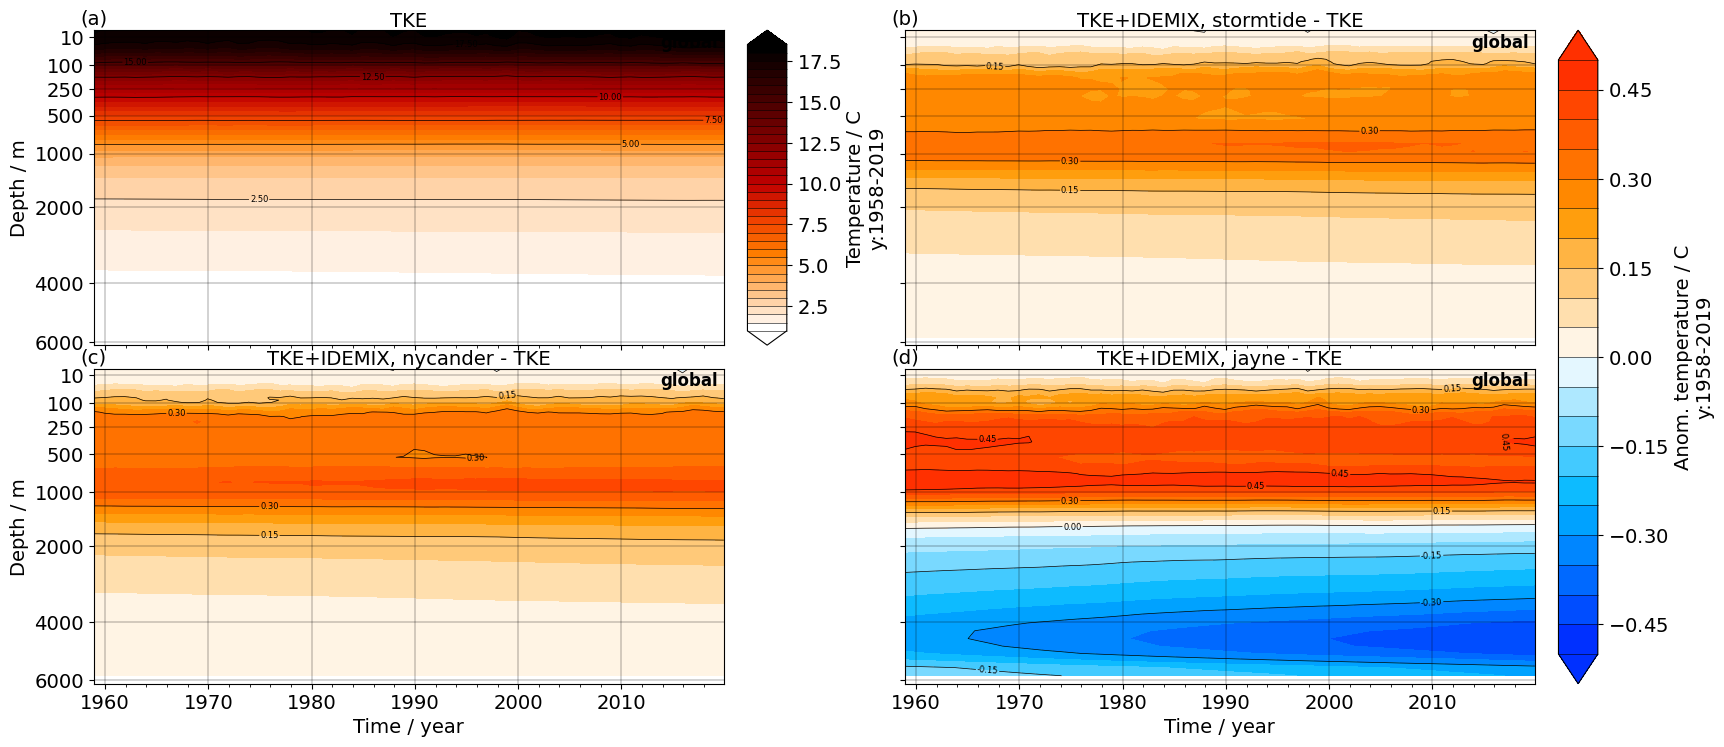

In [16]:
#______________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=2, ncol=2, box_idx=0, 
                                 cinfo=[dict({'cstr':'heat','cnum':20}),dict({'cstr':'blue2red','cnum':20, 'crange':[-0.5,0.5,0]})], 
                                 do_plt='cf', plt_contb=False, plt_contf=True, plt_contr=False, plt_contl=True, 
                                 ax_opt=dict({'fig_sizefac':2, 'cb_plt':[1,2,2,2], 'cb_plt_single':False}), 
                                 do_enum=True, 
                                 do_save=os.path.join(save_path,'test_vslice_hovm.png') )

# > Index vs. depth: vprofile

/albedo/home/pscholz/tripyview/tripyview ocean_basins/Arctic_Basin.shp
/albedo/home/pscholz/tripyview/tripyview ocean_basins/Eurasian_Basin.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/Canada_Basin.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/North_Atlantic_Ocean.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/Greenland_Sea.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/Irminger_Sea.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/Norwegian_Sea.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/Labrador_Sea.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/North_Pacific_Ocean.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/South_Pacific_Ocean.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/Southern_Ocean.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/Western_Weddell_Sea.shp
0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
1 /albedo/wor

[<Figure size 1307.08x1251.97 with 12 Axes>,
 [<Axes: title={'center': 'Arctic Basin'}, xlabel='Temperature / C', ylabel='Depth / m'>,
  <Axes: title={'center': 'Eurasian Basin'}, xlabel='Temperature / C'>,
  <Axes: title={'center': 'Canada Basin'}, xlabel='Temperature / C'>,
  <Axes: title={'center': 'North Atlantic Ocean'}, xlabel='Temperature / C'>,
  <Axes: title={'center': 'Greenland Sea'}, xlabel='Temperature / C', ylabel='Depth / m'>,
  <Axes: title={'center': 'Irminger Sea'}, xlabel='Temperature / C'>,
  <Axes: title={'center': 'Norwegian Sea'}, xlabel='Temperature / C'>,
  <Axes: title={'center': 'Labrador Sea'}, xlabel='Temperature / C'>,
  <Axes: title={'center': 'North Pacific Ocean'}, xlabel='Temperature / C', ylabel='Depth / m'>,
  <Axes: title={'center': 'South Pacific Ocean'}, xlabel='Temperature / C'>,
  <Axes: title={'center': 'Southern Ocean'}, xlabel='Temperature / C'>,
  <Axes: title={'center': 'Western Weddell Sea'}, xlabel='Temperature / C'>]]

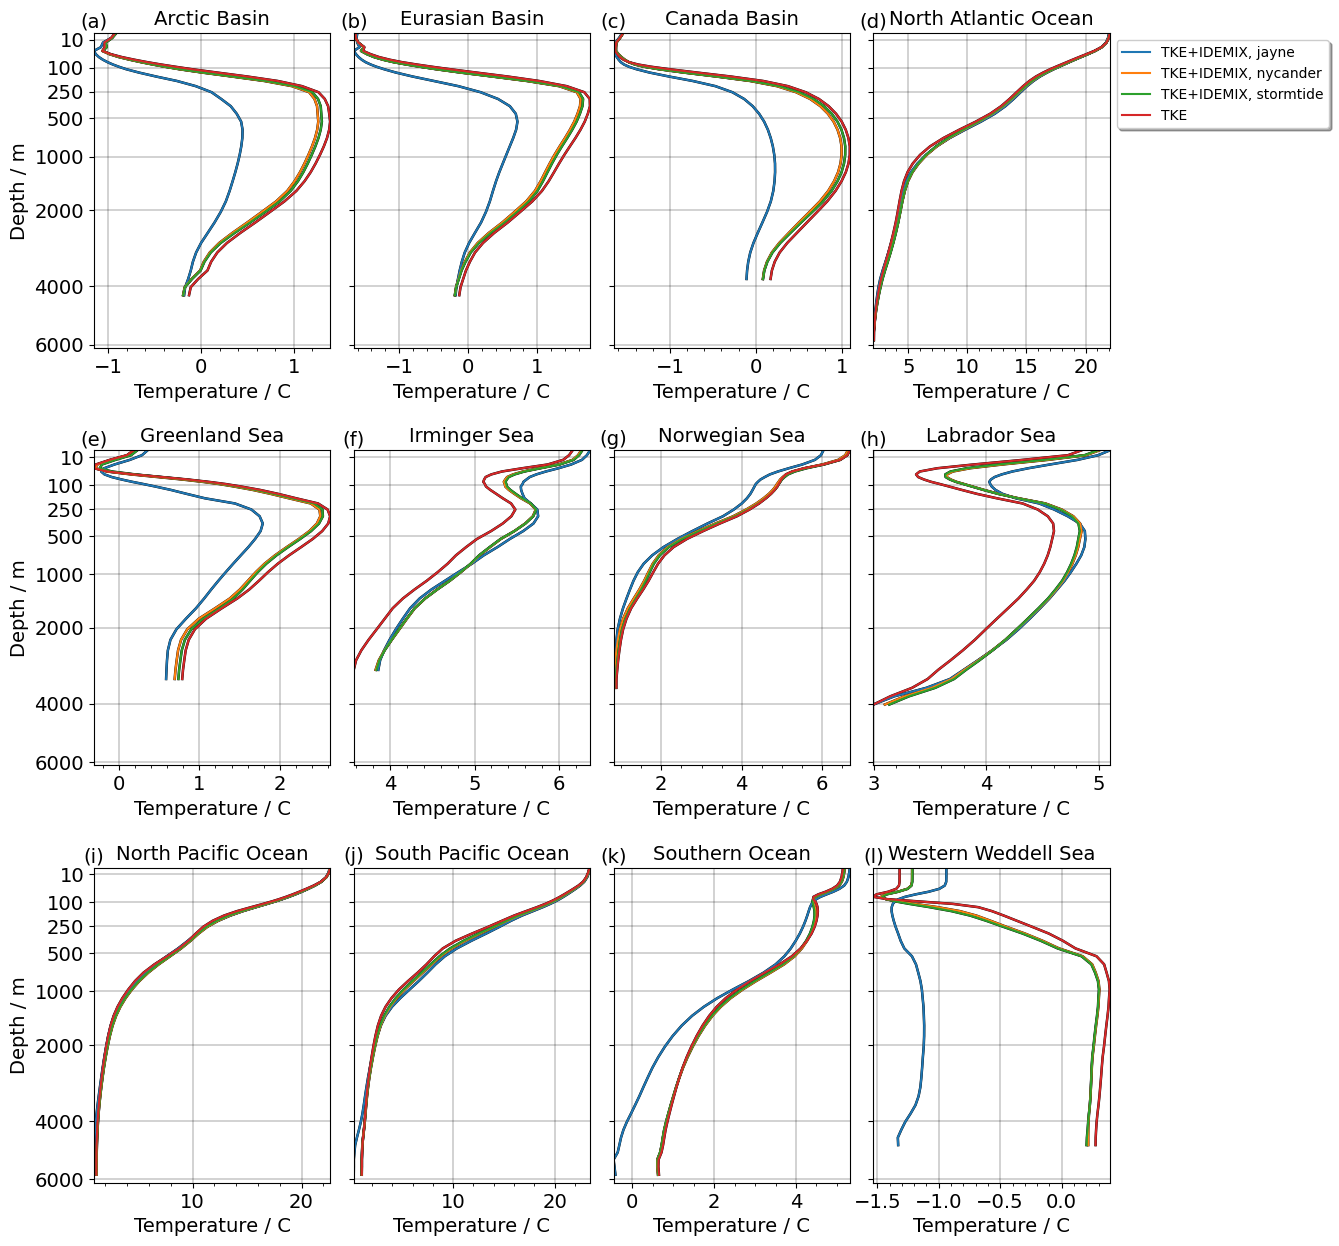

In [17]:
vname='temp'

box_regions = list()
box_regions.append('ocean_basins/Arctic_Basin.shp')
box_regions.append('ocean_basins/Eurasian_Basin.shp')
box_regions.append('mpas_region/Canada_Basin.shp')
box_regions.append('mpas_region/North_Atlantic_Ocean.shp')
box_regions.append('mpas_region/Greenland_Sea.shp')
box_regions.append('mpas_region/Irminger_Sea.shp')
box_regions.append('mpas_region/Norwegian_Sea.shp')
box_regions.append('mpas_region/Labrador_Sea.shp')
box_regions.append('mpas_region/North_Pacific_Ocean.shp')
box_regions.append('mpas_region/South_Pacific_Ocean.shp')
box_regions.append('mpas_region/Southern_Ocean.shp')
box_regions.append('mpas_region/Western_Weddell_Sea.shp')

#________________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
import shapefile as shp
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_regions:
    if region == 'global' or isinstance(region,list): 
        print('global')
        box.append(region)
    else: 
        print(tpv.__path__[0],region)
        box.append(shp.Reader(os.path.join(shp_path,region)))  
        
#______________________________________________________________________________________________________
# allocate lists
vprof_list  = list()
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None and ref_path != 'None'): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    
    #__________________________________________________________________________________________________
    data       = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, descript=descript , 
                                      do_info=False, do_zarithm=None, do_load=False, do_persist=True)
    
    #__________________________________________________________________________________________________    
    # create reference vert. profile if given 
    if (ii==0) and (ref_path != None and ref_path != 'None'):
        data_ref = tpv.load_index_fesom2(mesh, data_ref, box)
        
    #__________________________________________________________________________________________________  
    # create vert. profile --> collect the lines in a list
    data_index = tpv.load_index_fesom2(mesh, data, box)
    if  (ref_path != None and ref_path != 'None'): 
        vprof_list.append(tpv.do_indexanomaly(data_index, data_ref))
    else:
        vprof_list.append(data_index)

#______________________________________________________________________________________________________        
tpv.plot_vline(vprof_list           , 
                box        = None      , 
                box_idx    = None      ,
                box_label  = None      , 
                boxl_opt   = dict()    , # option for box label string 
                cinfo      = None      , # colormap info and defintion
                nrow       = 3         , # number of row in figures panel
                ncol       = 4         ,
                ax_opt=dict({'fig_sizefac':2}),
                do_enum    = True  ,
                do_save    = os.path.join(save_path,'test_vprofile.png')  
                 )#

# > Time-series

In [18]:
input_paths2, input_names2 = list(), list()
input_paths2.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/')
input_paths2.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_names2.append('TKE')
input_names2.append('TKE+IDEMIX')

n_cycl    = 5
do_allcycl= True
do_concat = True

vname     = 'temp'
year      = [1958, 2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
box_regions = list()
box_regions.append('global')

#_____________________________________________________________________________________
cycl_s=n_cycl   
if do_allcycl: cycl_s=1
aux_path, aux_name = list(), list()
input_paths_old, input_names_old = input_paths2, input_names2
for ii, (ipath, iname) in enumerate(zip(input_paths2,input_names2)):
    for ii_cycl in range(cycl_s, n_cycl+1):
        aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
        if not do_allcycl: aux_name.append('{}'.format(iname))
        else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
        print(ii, aux_path[-1],aux_name[-1])
input_paths2, input_names2 = aux_path, aux_name

#_____________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_regions:
    if region == 'global' or isinstance(region,list): 
        print('global')
        box.append(region)
    else: 
        print(tpv.__path__[0],region)
        box.append(shp.Reader(os.path.join(shp_path,region)))   

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/1/ 1) TKE
0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/2/ 2) TKE
0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/3/ 3) TKE
0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/4/ 4) TKE
0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ 5) TKE
1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/1/ 1) TKE+IDEMIX
1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/2/ 2) TKE+IDEMIX
1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/3/ 3) TKE+IDEMIX
1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/4/ 4) TKE+IDEMIX
1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ 5) TKE+IDEMIX
global


In [19]:
#___LOAD FESOM2 DATA___________________________________________________________________________________
vname = 'temp'
tseries_list  = list()
for ii, (datapath, descript) in enumerate(zip(input_paths2, input_names2)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    # load data and do vertical weighted mean 
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, descript=descript, 
                                do_tarithm='None', do_zarithm='None', do_zweight=True, do_info=False,
                                do_load=False, do_persist=True)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: 
        import warnings
        warnings.warn(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
        continue
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))

    # for heat content 
    rhow = 1025  # Seawater density in kg/m^3
    cp   = 3990  # Specific heat capacity of seawater in J/(kg K)
    data = data * rhow * cp
    data[vname].attrs['description'] = 'Ocean Heat Content (OHC)'
    data[vname].attrs['long_name'  ] = 'Ocean Heat Content (OHC)'
    data[vname].attrs['short_name' ] = 'OHC'
    data[vname].attrs['units'      ] = 'J'
    data = data.rename({vname:'OHC'})
    
    #__________________________________________________________________________________________________
    # select horizontal index region --> do horizontal weighted mean 
    ts = clock.time()
    data = tpv.load_index_fesom2(mesh, data, box, do_harithm='wint', do_zarithm='wint')
    print(' --> elasped time to comp. index.: {:3.2f} min.'.format( (clock.time()-ts)/60  )) 
    
    tseries_list.append(data)
    del(data)

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/1/ 1) TKE
 --> elasped time to load data: 0.08 min.
 --> data uses 1.40 Gb:
 --> elasped time to comp. index.: 0.03 min.
1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/2/ 2) TKE
 --> elasped time to load data: 0.08 min.
 --> data uses 1.40 Gb:
 --> elasped time to comp. index.: 0.03 min.
2 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/3/ 3) TKE
 --> elasped time to load data: 0.08 min.
 --> data uses 1.40 Gb:
 --> elasped time to comp. index.: 0.03 min.
3 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/4/ 4) TKE
 --> elasped time to load data: 0.08 min.
 --> data uses 1.40 Gb:
 --> elasped time to comp. index.: 0.03 min.
4 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ 5) TKE
 --> elasped time to load data: 0.07 min.
 --> data uses 1.40 Gb:
 --> elasped time to comp. index.: 0.03 min.
5 /albedo/

 > save figure: /albedo/home/pscholz/tripyview/Results/test_newploting/test_tseries.png


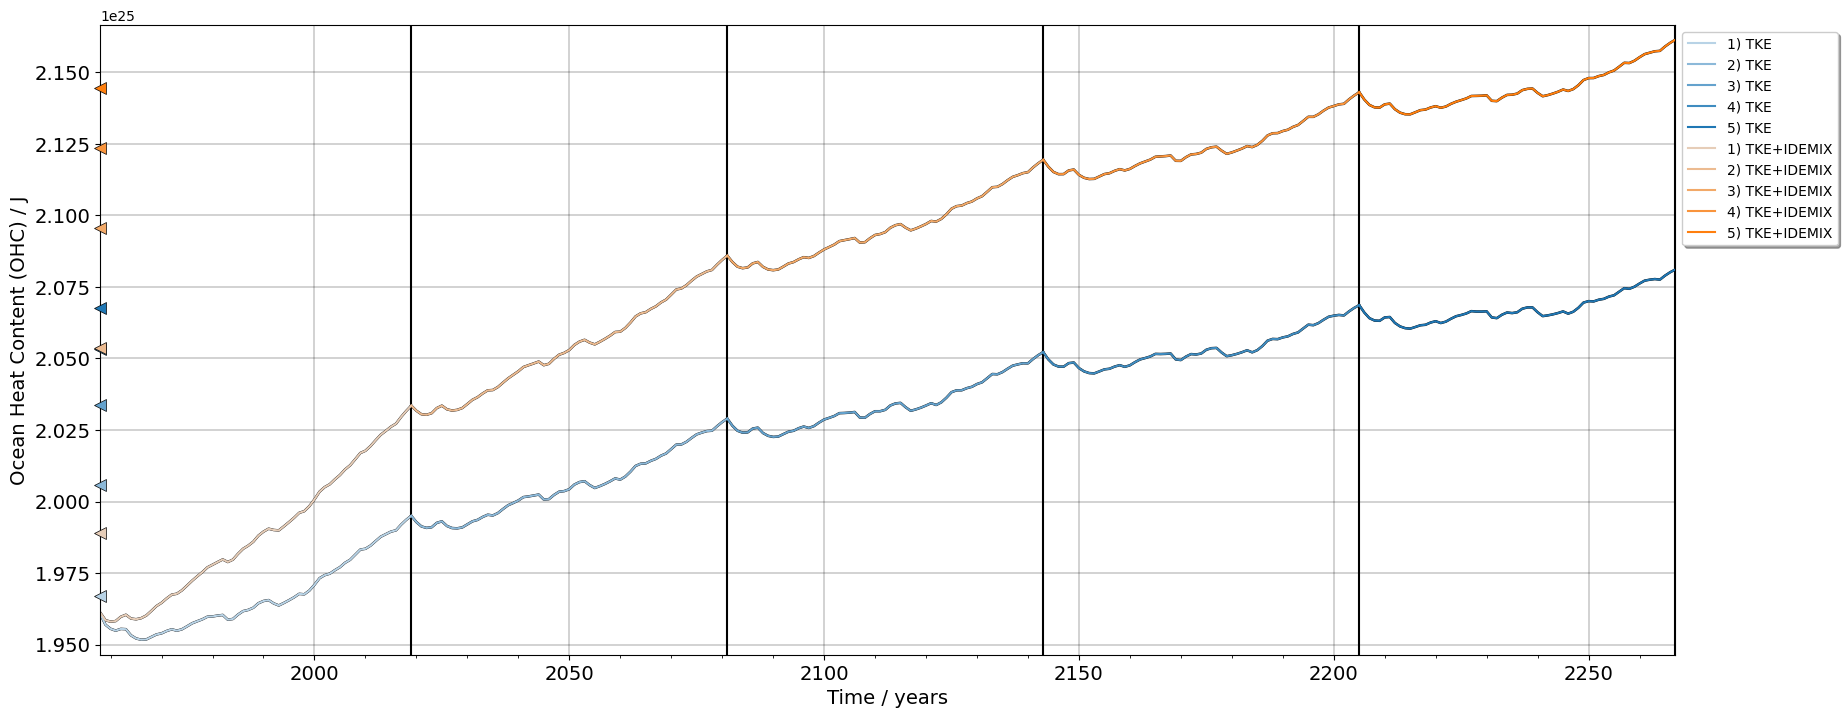

In [20]:
fig,ax=tpv.plot_tline(tseries_list, box, nrow=1, ncol=1, 
                        n_cycl     = 5, 
                        do_allcycl = True, 
                        do_concat  = True, 
                        ax_opt     = dict({'fig_sizefac':4}),
                        do_enum    = False  ,
                        do_save    = os.path.join(save_path,'test_tseries.png')  
                        )  

In [21]:
input_paths2, input_names2 = list(), list()
input_paths2.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/')
input_paths2.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_names2.append('TKE')
input_names2.append('TKE+IDEMIX') 

n_cycl    = 5
do_allcycl= False
do_concat = False
do_wbolus = True
which_lat = 26.5 # 'max' # 'max', 26.0
vname     = 'amoc'
year      = [1958, 2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
box_regions = list()
box_regions.append('global')

#_____________________________________________________________________________________
cycl_s=n_cycl
if do_allcycl: cycl_s=1  
aux_path, aux_name = list(), list()
input_paths_old, input_names_old = input_paths2, input_names2
for ii, (ipath, iname) in enumerate(zip(input_paths2,input_names2)):
    for ii_cycl in range(cycl_s, n_cycl+1):
        aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
        if not do_allcycl: aux_name.append('{}'.format(iname))
        else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
        print(ii, aux_path[-1],aux_name[-1])
input_paths2, input_names2 = aux_path, aux_name

#______________________________________________________________________________________________________
if not isinstance(which_lat, list): which_lat = list([which_lat])

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX


In [ ]:
zdefuc,zdeflc = [500,2000], [1500, 6000] # z-definition for upper/lower cell
list_zmoc     = list()
year_list     = list(range(year[0], year[1]+1))
chnk_size     = 5 # compute dmoc time-series in chunks of chnk_size years 
                   #-> you can use larger chunks here if you have enough memory
chnk_yrs_list = year_list[::chnk_size]
for datapath, descript in zip(input_paths2, input_names2): 
    print(datapath, descript)
    print(' > year:', end='')
    ts = clock.time()
    
    # compute dmoc time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='\n        ')
        #____________________________________________________________________________________________________
        # load vertical velocity --> use only annual mean datato compute moc 
        data = tpv.load_data_fesom2(mesh, datapath, vname='w', year=year_chnk, descript=descript , 
                                    do_info=False, do_tarithm='ymean', do_zarithm=None, do_nan=False, 
                                    do_load=False, do_persist=True, ) 
        if do_wbolus:
            data['w'].data = data['w'].data+tpv.load_data_fesom2(mesh, datapath, vname='bolus_w', year=year_chnk, 
                                        do_info=False, do_tarithm='ymean', do_zarithm=None, do_nan=False, 
                                        do_load=False, do_persist=True, )['bolus_w'].data #chunks=dict(data.chunksizes), 
        
        #____________________________________________________________________________________________________
        # compute moc profile over time
        zmoc  = tpv.calc_zmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=False, 
                              do_onelem=False, do_load=True, do_checkbasin=False, do_parallel=do_parallel, n_workers=parallel_nprc_bin)
        del(data)
        
        #____________________________________________________________________________________________________
        # compute time-series
        if  vname == 'ipmoc' or vname == 'pmoc':
            zmoc_tchnk = zmoc.where((zmoc['depth']>=zdeflc[0]) & (zmoc['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_aabw'})
        elif vname == 'amoc' or vname == 'aamoc':
            zmoc_nadw  = zmoc.where((zmoc['depth']>=zdefuc[0]) & (zmoc['depth']<=zdefuc[1])).max(dim='nz',skipna=True).rename({'zmoc':'zmoc_nadw'})
            zmoc_aabw  = zmoc.where((zmoc['depth']>=zdeflc[0]) & (zmoc['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_aabw'})
            zmoc_tchnk = xr.merge([zmoc_nadw, zmoc_aabw], compat='minimal' )
            del(zmoc_aabw, zmoc_nadw)
        if nchnk==0: zmoc_t = zmoc_tchnk
        else       : zmoc_t = xr.concat([zmoc_t, zmoc_tchnk], dim='time')
        #____________________________________________________________________________________________________
        del(zmoc, zmoc_tchnk)
        
    #____________________________________________________________________________________________________
    # moctseries_list.append([time, moc_t])    
    list_zmoc.append(zmoc_t)    
    del(zmoc_t)
    print(' --> elapsed time: {:3.2f}min.'.format((clock.time()-ts)/60.0))

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 > year:1958|1959|1960|1961|1962
        1963|1964|1965|1966|1967
        1968|1969|1970|1971|1972
        1973|1974|1975|1976|1977
        1978|1979|1980|1981|1982
        1983|1984|1985|1986|1987
        1988|1989|1990|1991|1992
        1993|1994|1995|1996|1997
        1998|1999|2000|2001|2002
        2003|2004|2005|2006|2007
        2008|2009|2010|2011|2012
        2013|2014|2015|2016|2017
        2018|2019
         --> elapsed time: 0.47min.
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX
 > year:1958|1959|1960|1961|1962
        1963|1964|1965|1966|1967
        1968|1969|1970|1971|1972
        1973|1974|1975|1976|1977
        1978|1979|1980|1981|1982
        1983|1984|1985|1986|1987
        1988|1989|1990|1991|1992
        1993|1994|1995|1996|1997
        1998|1999|2000|2001|2002
        2003|2004|2005|2006|2007
        2008|2009|2010|2011|2012


In [ ]:
    #___PLOT FESOM2 DATA________________________________________________________
    # plot strength of AMOC at lat
    for lat in which_lat: 
        list_lat = list()
        for data in list_zmoc:
            for var in data.data_vars:
                #_______________________________________________________________
                if var in ['zmoc_nadw','zmoc_ucell']:
                    data_lat = data[var].to_dataset(promote_attrs=True)
                    if lat=='max':
                        data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).max(dim='lat') 
                        str_label= f'@{40}°N<lat<{60}°N'
                    elif isinstance(lat, list):    
                        data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).max(dim='lat') 
                        str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                    else:     
                        data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                        if lat>=0: str_label= f'@{lat}°N'
                        else     : str_label= f'@{lat}°S'  
                    data_lat[var].attrs['add2ylabel'] = str_label
                    list_lat.append([data_lat])

        #_______________________________________________________________________
        fig,ax=tpv.plot_tline(list_lat, box, nrow=1, ncol=1, 
                            n_cycl     = 5, 
                            do_allcycl = False, 
                            do_concat  = False, 
                            plt_opt    = dict({'marker':'o'}),    
                            ax_opt     = dict({'fig_sizefac':4}),
                            do_enum    = False  ,
                            do_save    = os.path.join(save_path,f'test_tseries_{vname}_ucell_{lat}.png')  
                            )          

    #___PLOT FESOM2 DATA________________________________________________________
    # plot strength of AABW at lat
    for lat in which_lat: 
        list_lat = list()
        for data in list_zmoc:
            for var in data.data_vars:
                #_______________________________________________________________
                if var in ['zmoc_aabw','zmoc_lcell']:
                    data_lat = data[var].to_dataset(promote_attrs=True)
                    if lat=='max':
                        data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).min(dim='lat') 
                        str_label= f'@{40}°N<lat<{60}°N'
                    elif isinstance(lat, list):    
                        data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).min(dim='lat') 
                        str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                    else:     
                        data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                        if lat>=0: str_label= f'@{lat}°N'
                        else     : str_label= f'@{lat}°S'  
                    data_lat[var].attrs['add2ylabel'] = str_label
                    data_lat[var].attrs['short_name'] = 'AABW'
                    data_lat[var].attrs['long_name']  = 'AABW'
                    list_lat.append([data_lat])

        #_______________________________________________________________________
        fig,ax=tpv.plot_tline(list_lat, box, nrow=1, ncol=1, 
                            n_cycl     = 5, 
                            do_allcycl = False, 
                            do_concat  = False, 
                            plt_opt    = dict({'marker':'o'}),    
                            ax_opt     = dict({'fig_sizefac':4}),
                            do_enum    = False  ,
                            do_save    = os.path.join(save_path,f'test_tseries_{vname}_lcell_{lat}.png')  
                            )          
